<a href="https://colab.research.google.com/github/Khadijah-Trawally/QuantumGraphColoring/blob/main/test_graph_coloring_hamiltonian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import os

import numpy as np

import matplotlib.pyplot as plt
from scipy.linalg import eigh
import networkx as nx


In [2]:
def draw_graph(N, edges):
    """
    Generate and draw a graph with a given structure

    Parameters
    ----------
    num_nodes : int
        Number of nodes of the graph
    edges : list of tuples of ints
        Edges of the graph

    Returns
    -------
    nx.Graph
        Graph object
    """
    graph = nx.Graph()
    graph.add_nodes_from([ii for ii in range(N)])
    graph.add_edges_from(edges)
    nx.draw(graph, with_labels=True, node_size=700)


    return graph

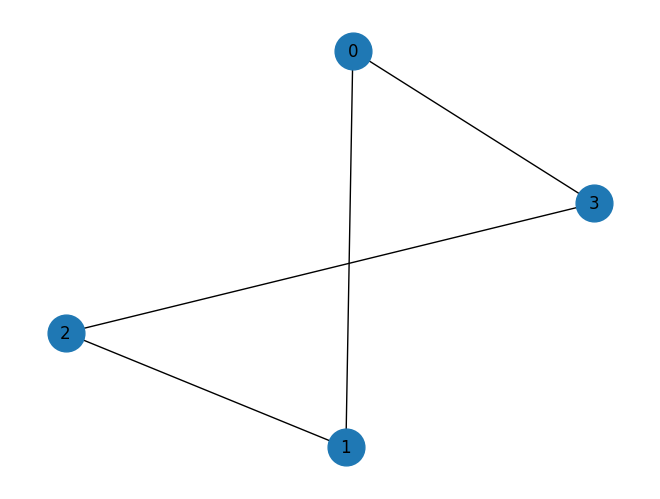

In [3]:
edges = [(0, 1), (1, 2), (2, 3), (0 , 3)]
num_nodes = 4


G = draw_graph(num_nodes, edges)
G



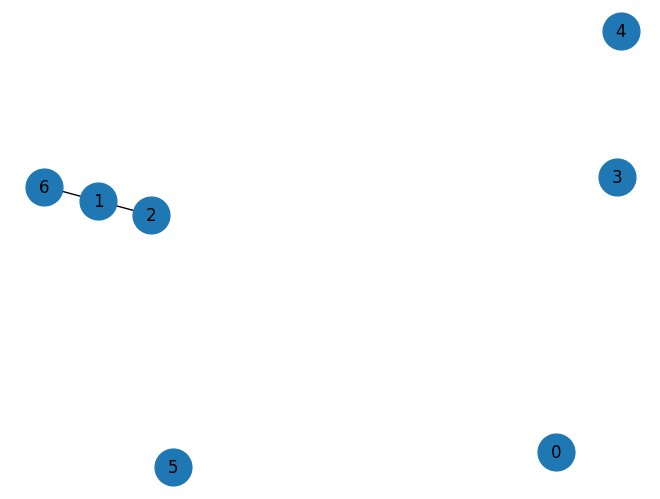

In [4]:
edges_rant = [(1, 2), (1,
                       6)]
num_nodes = 6
draw_graph(num_nodes, edges_rant)

In [5]:
def get_1d_index(i, k, c):
    """
    Convert 2D index (i, k) to a 1D index in a grid with 'c' number of columns.

    Parameters:
    i (int): Node index.
    k (int): Color index.
    c (int): Number of colors.

    Returns:
    int: Corresponding 1D index.
    """
    return i * c + k

def constant_terms(N, C, graph, lambda1, lambda2):
    """
    Construct the constants P for the Hamiltonian.

    Parameters:
    N (int): Number of nodes.
    C (int): Number of colors.
    graph (networkx.Graph): Graph representing the nodes and edges.
    lambda1 (float): Coefficient for the first two terms.
    lambda2 (float): Coefficient for the third term.

    Returns:
    P (float): constant in the Hamiltonian.

    """
    E = graph.number_of_edges()
    P = 0.25 * lambda1 * (4 * N * C + N * C * (C - 3)) + 0.25 * lambda2 * C * E

    return P





def magnetic_fields(N, C, graph, lambda1, lambda2):
    """
    Construct the magnetic fields h for the Hamiltonian.

    Parameters:
    N (int): Number of nodes.
    C (int): Number of colors.
    graph (networkx.Graph): Graph representing the nodes and edges.
    lambda1 (float): Coefficient for the first two terms.
    lambda2 (float): Coefficient for the third term.

    Returns:
    numpy.ndarray: Magnetic fields vector.
    """
    # sigmaz = np.array([[1, 0], [0, -1]], dtype=complex)
    dim = N * C
    h = np.zeros(dim, dtype=complex)

    # First term: (1/2) * lambda1 * sum_{i=1}^{n} sum_{k=1}^{c} (c-k-1) * sigma_{ik}
    for i in range(N):
        for k in range(C):
            ik = get_1d_index(i, k, C)
            coefficient = (C - k - 1)
            h[ik] += 0.5 * lambda1 * coefficient

    # Second term: (1/2) * lambda1 * sum_{i=1}^{n} sum_{k' > k=1}^{c} sigma_{ik'}
    for i in range(N):
        for k in range(C - 1):
            for k_prime in range(k + 1, C):
                ik_prime = get_1d_index(i, k_prime, C)
                h[ik_prime] += 0.5 * lambda1

    # Third term: (1/4) * lambda2 * sum_{(i,j) in E} sum_{k=1}^{c} (sigma_{ik} + sigma_{jk})
    for i, j in graph.edges:
        for k in range(C):
            ik = get_1d_index(i, k, C)
            jk = get_1d_index(j, k, C)
            h[ik] += 0.25 * lambda2
            h[jk] += 0.25 * lambda2

    return h

def interaction_strengths(N, C, graph, lambda1, lambda2):
    """
    Construct the interaction strengths matrix J.

    Parameters:
    N (int): Number of nodes.
    C (int): Number of colors.
    graph (networkx.Graph): Graph representing the nodes and edges.
    lambda1 (float): penalty constant, Coefficient for the first term.
    lambda2 (float): penalty constant, Coefficient for the second term.

    Returns:
    numpy.ndarray: Interaction strengths matrix J.
    """
    dim = N * C
    J = np.zeros((dim, dim), dtype=complex)

    # First term: (1/2) * lambda1 * sum_{i=1}^{n} sum_{k' > k=1}^{c} sigma_{ik} sigma_{ik'}
    for i in range(N):
        for k in range(C - 1):
            for k_prime in range(k + 1, C):
                ik = get_1d_index(i, k, C)
                ik_prime = get_1d_index(i, k_prime, C)
                J[ik, ik_prime] = 0.5 * lambda1

    # Second term: (1/4) * lambda2 * sum_{(i,j) in E} sum_{k=1}^{c} sigma_{ik} sigma_{jk}
    for i, j in graph.edges:
        for k in range(C):
            ik = get_1d_index(i, k, C)
            jk = get_1d_index(j, k, C)
            J[ik, jk] = 0.25 * lambda2

    return J



if __name__ == '__main__':
    n = 4  # Number of nodes
    c = 2  # Number of colors
    lambda1 = 4.0
    lambda2 = 2.0


    # Construct the constants
    P = constant_terms(n, c, G, lambda1, lambda2)
    print('constant term P:\n', P, '\n')

    # Construct the magnetic fields
    h = magnetic_fields(n, c, G, lambda1, lambda2)
    print('Magnetic fields h:\n', h.shape, '\n')

    # Construct the interaction strengths matrix
    J = interaction_strengths(n, c, G, lambda1, lambda2)
    print('Interaction strengths matrix J:\n', J.shape)



constant term P:
 28.0 

Magnetic fields h:
 (8,) 

Interaction strengths matrix J:
 (8, 8)


In [6]:

def tensor_product(Mat1, Mat2):
  """
  Compute the tensor product of two matrices.

  Parameters:
  Mat1 (array): First matrix.
  Mat2 (array): Second matrix.

  Returns:
  array: Tensor product of the input matrices.
  """
  return np.kron(Mat1, Mat2)

def identity_matrix(dim):
  """
  Generate an identity matrix of size 2^dim.

  Parameters:
  dim (int): Exponent for the size of the identity matrix.

  Returns:
  array: Identity matrix of size 2^dim x 2^dim.
  """
  return np.eye(2**dim)


def single_spin_hamiltonian(N):
  """
  Construct the single spin Hamiltonian for N nodes and C colors with given magnetic fields.

  Parameters:
  N (int): Number of nodes.


  Returns:
  numpy.ndarray: Single spin Hamiltonian matrix.
  """
  sigmaz = np.array([[1, 0], [0, -1]], dtype=complex)


  H0 = np.zeros((2**N, 2**N), dtype=complex)
  for i in range(N):

    H0 += tensor_product(tensor_product(identity_matrix(i), sigmaz),
                                    identity_matrix(N - i - 1))
    #print(H0.shape)

  return H0


def interacting_spin_hamiltonian(N):
    """
    Construct the interacting Hamiltonian for the system.

    Parameters:
    N (int): Number of nodes.



    Returns:
    numpy.ndarray: Interacting Hamiltonian matrix.
    """
    H_int = np.zeros((2**N, 2**N), dtype=complex)
    sigmaz = np.array([[1, 0], [0, -1]], dtype=complex)

    for i in range(1, N):

      H_int += tensor_product(tensor_product(tensor_product(identity_matrix(i-1),
                                                        sigmaz), sigmaz),
                          identity_matrix(N-i-1))
      #print(H_int.shape)

    return H_int



In [33]:
def generate_ising_hamiltonian(N, C, G, cont, h, J):

    """
    Generate an ising Hamiltonian for graph coloring
    Param:
    N (int): Number of nodes.
    C (int): Number of colors.
    G (networkx.Graph): Graph representing the nodes and edges.
    P (float): constant in the Hamiltonian.
    h (ndarray): magnetic field vector.
    J (ndarray): Interaction strengths matrix.
    lambda1 and lambda2 (float):  penalty constants

    Returns:
    numpy.ndarray: Ising Hamiltonian matrix.

    """
    for  i in range(N*C):
      for j in range(i+1, N*C):
        ham = cont * identity_matrix(N) + h[i] * single_spin_hamiltonian(N) + \
            J[i, j]* interacting_spin_hamiltonian(N)

    return ham

def ground_state_solution(ham):
    eigen_val, eigen_vec = eigh(ham)
    print(f'Eigenvalues of the Hamiltonian: {eigen_val} \n')

    ground_energy = np.min(eigen_val)

    idx = np.where(np.isclose(eigen_val, ground_energy))[0]

    ground_states = eigen_vec[:, idx]

    return  ground_energy, ground_states




if __name__ == '__main__':

    n = 4  # Number of nodes
    c = 2  # Number of colors
    lambda1 = 4.0
    lambda2 = -2.0


    # Construct the constants
    P = constant_terms(n, c, G, lambda1, lambda2)
    #print('constant term P:\n', P, '\n')

    # Construct the magnetic fields
    h = magnetic_fields(n, c, G, lambda1, lambda2)
    #print('Magnetic fields h:\n', h, '\n')

    # Construct the interaction strengths matrix
    J = interaction_strengths(n, c, G, lambda1, lambda2)
    #print('Interaction strengths matrix J:\n', J)


    hamiltonian = generate_ising_hamiltonian(n, c, G, P, h, J )

    ground_energy, ground_state  = ground_state_solution(hamiltonian)

    print(f'The ground state energy: {ground_energy} \n' )

    print(f'The ground state solution:  \n {ground_state}')











Eigenvalues of the Hamiltonian: [13. 13. 15. 15. 17. 17. 19. 19. 19. 19. 21. 21. 21. 23. 23. 29.] 

The ground state energy: 13.0 

The ground state solution:  
 [[0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
